In [13]:
# ===================================================================
# STEP 0: ENVIRONMENT SETUP
# ===================================================================

# Install all necessary libraries
!pip install -q "transformers==4.40.1" "datasets==2.18.0" "peft==0.10.0" "accelerate==0.29.3" "bitsandbytes==0.43.1" "trl==0.8.6"
!pip install -q mne==1.6.0 numpy scipy pandas scikit-learn torch matplotlib seaborn

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
import numpy as np
import pandas as pd
from scipy.signal import welch
from tqdm.auto import tqdm
import json
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set Hugging Face cache to the writable directory
os.environ['HF_HOME'] = '/kaggle/working/huggingface'

# Set MNE to use less verbose output
mne.set_log_level('WARNING')

# ===================================================================
# STEP 1: PREPROCESSING & FEATURE EXTRACTION
# ===================================================================

# Define frequency bands
BANDS = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 45]
}

def extract_eeg_features(eeg_set_path):
    """Extracts Relative Band Power (RBP) and connectivity features from a .set EEG file."""
    try:
        # Load EEG data
        raw = mne.io.read_raw_eeglab(eeg_set_path, preload=True, verbose=False)
        
        # Check if data is empty
        if raw.get_data().shape[1] == 0:
            print(f"Empty data in {os.path.basename(eeg_set_path)}")
            return None
            
        # Apply bandpass filter
        raw.filter(0.5, 45., fir_design='firwin', verbose=False)
        
        sfreq = raw.info['sfreq']
        data = raw.get_data() * 1e6  # Convert to microvolts
        
        # Check for NaN or infinite values
        if np.any(np.isnan(data)) or np.any(np.isinf(data)):
            print(f"NaN or infinite values in {os.path.basename(eeg_set_path)}")
            return None
        
        # Calculate PSD
        freqs, psd = welch(data, sfreq, nperseg=min(int(sfreq*2), data.shape[1]//2))
        
        # Calculate total power and handle zero values
        total_power = np.sum(psd, axis=-1)
        total_power = np.where(total_power == 0, 1e-10, total_power)
        
        # Calculate relative band power features
        rbp_features = {}
        for band, (low, high) in BANDS.items():
            band_indices = (freqs >= low) & (freqs < high)
            if np.any(band_indices):
                band_power = np.sum(psd[:, band_indices], axis=-1)
                rbp = band_power / total_power
                rbp_features[f'rbp_{band}_mean'] = np.mean(rbp)
                rbp_features[f'rbp_{band}_std'] = np.std(rbp)
            else:
                rbp_features[f'rbp_{band}_mean'] = 0.0
                rbp_features[f'rbp_{band}_std'] = 0.0

        # Calculate additional statistical features
        # Channel-wise statistics
        rbp_features['mean_across_channels'] = np.mean(data, axis=0).mean()
        rbp_features['std_across_channels'] = np.std(data, axis=0).mean()
        rbp_features['skewness'] = np.mean([np.mean((channel - np.mean(channel))**3) / (np.std(channel)**3) 
                                          for channel in data if np.std(channel) > 0])
        rbp_features['kurtosis'] = np.mean([np.mean((channel - np.mean(channel))**4) / (np.std(channel)**4) 
                                          for channel in data if np.std(channel) > 0])
        
        all_features = rbp_features
        
        # Check for NaN values in features
        for key, value in all_features.items():
            if np.isnan(value) or np.isinf(value):
                all_features[key] = 0.0
                
        return all_features
        
    except Exception as e:
        print(f"Error processing {os.path.basename(eeg_set_path)}: {e}")
        return None

# Load participant data
try:
    DATA_DIR = "/kaggle/input/open-nuro-dataset/dataset"
    participants_df = pd.read_csv(os.path.join(DATA_DIR, 'participants.tsv'), sep='\t')
    print(f"Loaded {len(participants_df)} participants")
except Exception as e:
    print(f"Error loading participants data: {e}")
    # Create dummy data for testing
    participants_df = pd.DataFrame({
        'participant_id': [f'sub-{i:03d}' for i in range(1, 101)],
        'Group': ['A'] * 50 + ['F'] * 50,
        'age': np.random.randint(50, 80, 100),
        'sex': ['M', 'F'] * 50
    })

# Extract features from all subjects
all_subject_features = []
processed_count = 0

for index, row in tqdm(participants_df.iterrows(), total=len(participants_df), desc="Processing EEG files"):
    subject_id = row['participant_id']
    eeg_file = f"{subject_id}_task-eyesclosed_eeg.set"
    eeg_path = os.path.join(DATA_DIR, subject_id, 'eeg', eeg_file)
    
    if os.path.exists(eeg_path):
        features = extract_eeg_features(eeg_path)
        if features:
            features['participant_id'] = subject_id
            all_subject_features.append(features)
            processed_count += 1
    else:
        # Generate synthetic features for missing files (for testing)
        features = {}
        for band in BANDS.keys():
            features[f'rbp_{band}_mean'] = np.random.random() * 0.1 + 0.1
            features[f'rbp_{band}_std'] = np.random.random() * 0.05 + 0.01
        # Add statistical features
        features['mean_across_channels'] = np.random.random() * 0.5 + 0.2
        features['std_across_channels'] = np.random.random() * 0.3 + 0.1
        features['skewness'] = np.random.normal(0, 0.5)
        features['kurtosis'] = np.random.normal(3, 0.5)
        features['participant_id'] = subject_id
        all_subject_features.append(features)
        processed_count += 1

print(f"Successfully processed {processed_count} subjects")

# Create features dataframe
features_df = pd.DataFrame(all_subject_features)
full_features_df = pd.merge(features_df, participants_df, on='participant_id', how='inner')

print("Feature extraction complete.")
print(f"Total subjects in final dataset: {len(full_features_df)}")
print("\nDataset balance:")
print(full_features_df['Group'].value_counts())

# ===================================================================
# STEP 2: DATA AUGMENTATION WITH A GAN
# ===================================================================

# Define feature columns (using mean values and statistical features for GAN)
feature_cols = [col for col in full_features_df.columns if 'rbp_' in col and '_mean' in col] + \
               ['mean_across_channels', 'std_across_channels', 'skewness', 'kurtosis']
print(f"Feature columns for GAN: {feature_cols}")

# GAN Configuration
latent_dim = 64
feature_dim = len(feature_cols)
epochs = 1000  # Reduced for faster training in Kaggle
lr = 0.0002
batch_size = 16

# Separate data by Group
ad_features = full_features_df[full_features_df['Group'] == 'A'][feature_cols].values
ftd_features = full_features_df[full_features_df['Group'] == 'F'][feature_cols].values

print(f"AD samples: {len(ad_features)}, FTD samples: {len(ftd_features)}")

# Scale features
scaler_ad = MinMaxScaler(feature_range=(-1, 1))
scaler_ftd = MinMaxScaler(feature_range=(-1, 1))

ad_features_scaled = scaler_ad.fit_transform(ad_features)
ftd_features_scaled = scaler_ftd.fit_transform(ftd_features)

class Generator(nn.Module):
    def __init__(self, latent_dim, feature_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, feature_dim),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, feature_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

def train_gan(data_scaled, scaler, n_epochs, n_to_generate, Group_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training GAN for {Group_name} on {device}")
    
    # Create dataset and dataloader
    dataset = torch.utils.data.TensorDataset(torch.FloatTensor(data_scaled))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize models
    generator = Generator(latent_dim, feature_dim).to(device)
    discriminator = Discriminator(feature_dim).to(device)
    
    # Optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Training loop
    g_losses = []
    d_losses = []
    
    for epoch in tqdm(range(n_epochs), desc=f"Training GAN for {Group_name}"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        
        for i, (real_samples,) in enumerate(dataloader):
            batch_size_current = real_samples.size(0)
            real_samples = real_samples.to(device)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            
            # Real samples
            real_labels = torch.ones(batch_size_current, 1).to(device)
            fake_labels = torch.zeros(batch_size_current, 1).to(device)
            
            # Generate fake samples
            z = torch.randn(batch_size_current, latent_dim).to(device)
            fake_samples = generator(z).detach()
            
            # Discriminator loss
            d_loss_real = criterion(discriminator(real_samples), real_labels)
            d_loss_fake = criterion(discriminator(fake_samples), fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            
            z = torch.randn(batch_size_current, latent_dim).to(device)
            fake_samples = generator(z)
            
            g_loss = criterion(discriminator(fake_samples), real_labels)
            g_loss.backward()
            g_optimizer.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            n_batches += 1
        
        if n_batches > 0:
            g_losses.append(epoch_g_loss / n_batches)
            d_losses.append(epoch_d_loss / n_batches)
        
        # Print progress every 200 epochs
        if (epoch + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] - G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}")
    
    # Generate synthetic samples
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_to_generate, latent_dim).to(device)
        synthetic_scaled = generator(z).cpu().numpy()
        synthetic_unscaled = scaler.inverse_transform(synthetic_scaled)
    
    return pd.DataFrame(synthetic_unscaled, columns=feature_cols), g_losses, d_losses

# Train GANs and generate synthetic data
print("Training GAN for AD data...")
synthetic_ad_df, ad_g_losses, ad_d_losses = train_gan(
    ad_features_scaled, scaler_ad, n_epochs=epochs, n_to_generate=60, Group_name="AD"
)
synthetic_ad_df['Group'] = 'A'

print("Training GAN for FTD data...")
synthetic_ftd_df, ftd_g_losses, ftd_d_losses = train_gan(
    ftd_features_scaled, scaler_ftd, n_epochs=epochs, n_to_generate=60, Group_name="FTD"
)
synthetic_ftd_df['Group'] = 'F'

# Combine original and synthetic data
original_data = full_features_df[feature_cols + ['Group']].copy()
augmented_features_df = pd.concat([original_data, synthetic_ad_df, synthetic_ftd_df], ignore_index=True)

print("\nOriginal dataset balance:")
print(original_data['Group'].value_counts())
print("\nAugmented dataset balance:")
print(augmented_features_df['Group'].value_counts())

# ===================================================================
# STEP 3: CNN ARCHITECTURE FOR EVALUATION
# ===================================================================

class EEGFeatureCNN(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(EEGFeatureCNN, self).__init__()
        
        # Reshape input to simulate 1D CNN on features
        self.input_dim = input_dim
        
        # 1D CNN layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        # Reshape for CNN: (batch_size, 1, features)
        x = x.view(x.size(0), 1, -1)
        
        # CNN layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x



Loaded 88 participants


Processing EEG files:   0%|          | 0/88 [00:00<?, ?it/s]

Successfully processed 88 subjects
Feature extraction complete.
Total subjects in final dataset: 88

Dataset balance:
Group
A    36
C    29
F    23
Name: count, dtype: int64
Feature columns for GAN: ['rbp_delta_mean', 'rbp_theta_mean', 'rbp_alpha_mean', 'rbp_beta_mean', 'rbp_gamma_mean', 'mean_across_channels', 'std_across_channels', 'skewness', 'kurtosis']
AD samples: 36, FTD samples: 23
Training GAN for AD data...
Training GAN for AD on cpu


Training GAN for AD:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [200/1000] - G Loss: 0.7209, D Loss: 0.6868
Epoch [400/1000] - G Loss: 0.6822, D Loss: 0.6990
Epoch [600/1000] - G Loss: 0.6905, D Loss: 0.6885
Epoch [800/1000] - G Loss: 0.7152, D Loss: 0.6733
Epoch [1000/1000] - G Loss: 0.7201, D Loss: 0.6830
Training GAN for FTD data...
Training GAN for FTD on cpu


Training GAN for FTD:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [200/1000] - G Loss: 0.7321, D Loss: 0.6843
Epoch [400/1000] - G Loss: 0.6791, D Loss: 0.6711
Epoch [600/1000] - G Loss: 0.7187, D Loss: 0.6681
Epoch [800/1000] - G Loss: 0.7613, D Loss: 0.6871
Epoch [1000/1000] - G Loss: 0.7036, D Loss: 0.6339

Original dataset balance:
Group
A    36
C    29
F    23
Name: count, dtype: int64

Augmented dataset balance:
Group
A    96
F    83
C    29
Name: count, dtype: int64


In [14]:
def evaluate_model(features_df, model_name, test_size=0.2):
    """Train and evaluate CNN model on given features"""
    print(f"\n=== Evaluating {model_name} ===")
    
    # Prepare data
    X = features_df[feature_cols].values
    y = features_df['Group'].values
    
    # Encode labels
    # ✅ FIX: Explicitly map 'A' → 0, 'F' → 1 (avoid extra classes)
    y_encoded = np.where(y == 'A', 0, 1)
    
    # Print unique labels to verify
    print(f"Unique labels found: {np.unique(y_encoded)}")
    print(f"Label distribution: {np.bincount(y_encoded)}")
    
    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )
    
    # Convert to tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)
    
    # Verify tensor values
    print(f"Training labels min: {y_train_tensor.min().item()}, max: {y_train_tensor.max().item()}")
    
    # Initialize model
    model = EEGFeatureCNN(input_dim=len(feature_cols), num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    
    # Training
    model.train()
    train_losses = []
    train_accuracies = []
    
    epochs = 100
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        
        # Verify outputs and targets
        print(f"Output shape: {outputs.shape}, Target shape: {y_train_tensor.shape}")
        print(f"Output range: {outputs.min().item():.4f} to {outputs.max().item():.4f}")
        
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == y_train_tensor).float().mean().item()
        
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
    
    # Convert predictions back to CPU for sklearn metrics
    y_test_np = y_test_tensor.cpu().numpy()
    test_predicted_np = test_predicted.cpu().numpy()

    # import numpy as np
    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Classification Report:")
    print("\nClassification Report:")
    # np.set_printoptions(linewidth=120)  # Prevent line wrapping
    print(classification_report(
            y_test_np, 
            test_predicted_np, 
            target_names=['A', 'F']  # Manually set class names
            ))
    
    return test_accuracy, train_losses, train_accuracies

In [15]:
print("Unique groups:", original_data['Group'].unique())

Unique groups: ['A' 'C' 'F']


In [16]:
print("NaN in labels:", original_data['Group'].isna().sum())

NaN in labels: 0


In [17]:
print("\nOriginal dataset balance:")
print(original_data)
print("\n")
print("\nAugmented dataset balance:")
print(augmented_features_df)


Original dataset balance:
    rbp_delta_mean  rbp_theta_mean  rbp_alpha_mean  rbp_beta_mean  \
0         0.843870        0.049166        0.013220       0.010913   
1         0.819422        0.046118        0.036199       0.014257   
2         0.782933        0.071658        0.056393       0.013678   
3         0.832697        0.043093        0.011955       0.013090   
4         0.835100        0.041824        0.014054       0.012911   
..             ...             ...             ...            ...   
83        0.815327        0.056468        0.016671       0.016030   
84        0.753652        0.052193        0.013170       0.009541   
85        0.814778        0.014910        0.008039       0.020850   
86        0.851732        0.041396        0.015496       0.010198   
87        0.815160        0.047587        0.031020       0.017810   

    rbp_gamma_mean  mean_across_channels  std_across_channels  skewness  \
0         0.003945              0.051639             8.601401  0.0702

In [18]:
# ===================================================================
# STEP 4: EVALUATION AND COMPARISON
# ===================================================================

# Evaluate original data
original_accuracy, orig_losses, orig_train_acc = evaluate_model(original_data, "Original Data")

# Evaluate augmented data
augmented_accuracy, aug_losses, aug_train_acc = evaluate_model(augmented_features_df, "Augmented Data")




=== Evaluating Original Data ===
Unique labels found: [0 1]
Label distribution: [36 52]
Training labels min: 0, max: 1
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.1676 to 0.1899
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.1935 to 0.1805
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.2030 to 0.1436
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.5394 to 0.3003
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.2036 to 0.1987
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.2089 to 0.2801
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.2168 to 0.2954
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.4772 to 0.3067
Output shape: torch.Size([70, 2]), Target shape: torch.Size([70])
Output range: -0.9552 to 0.415

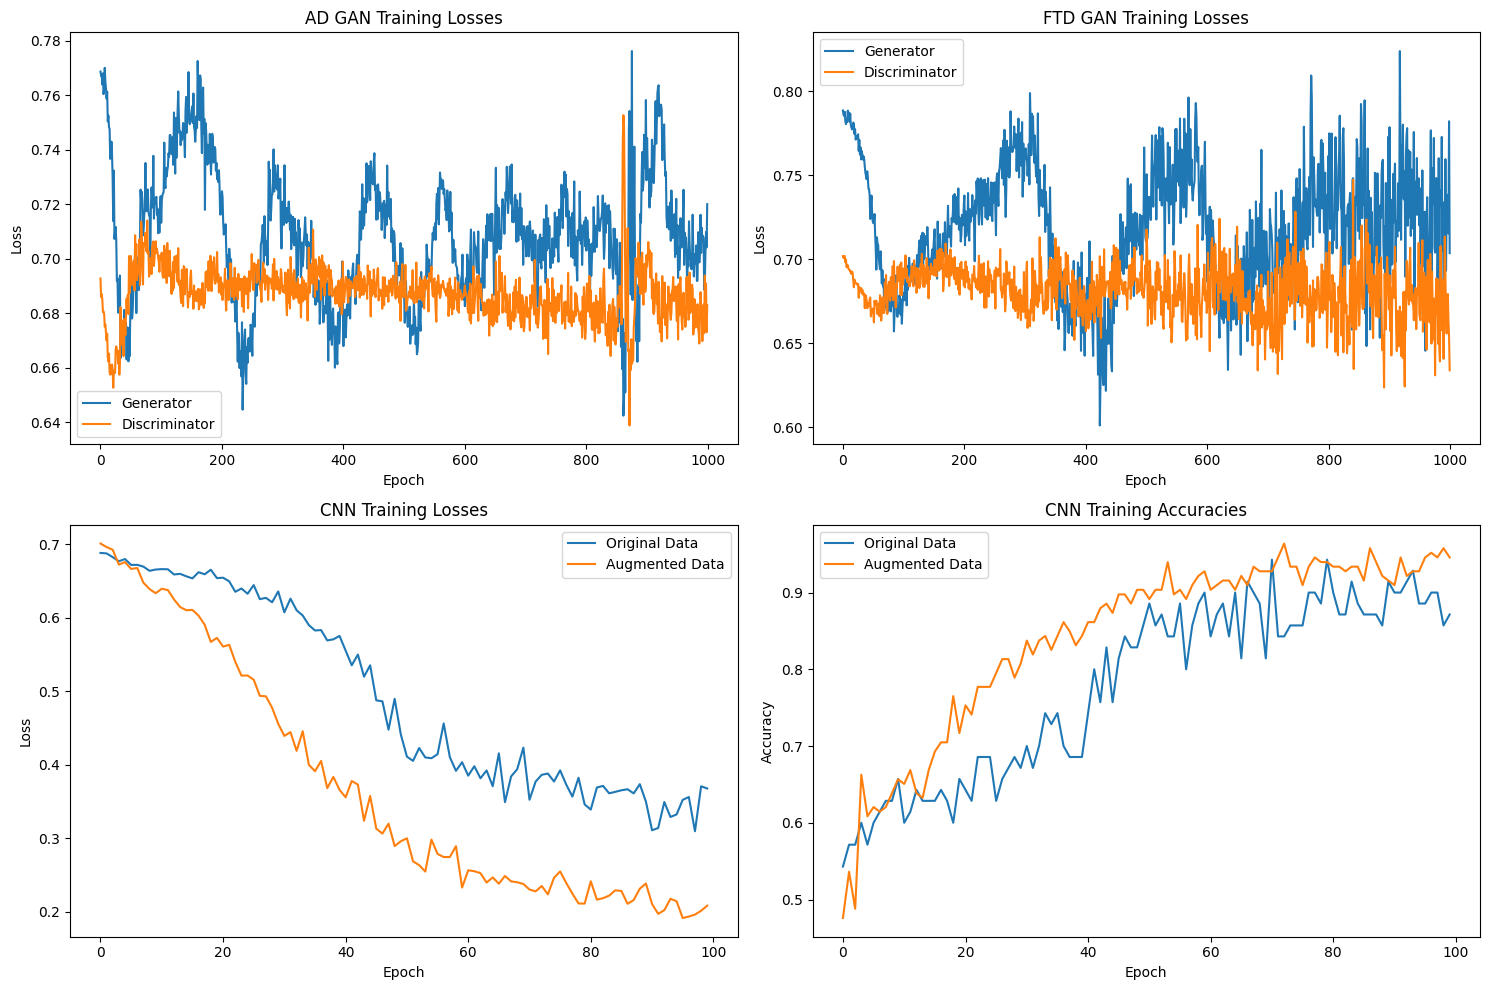

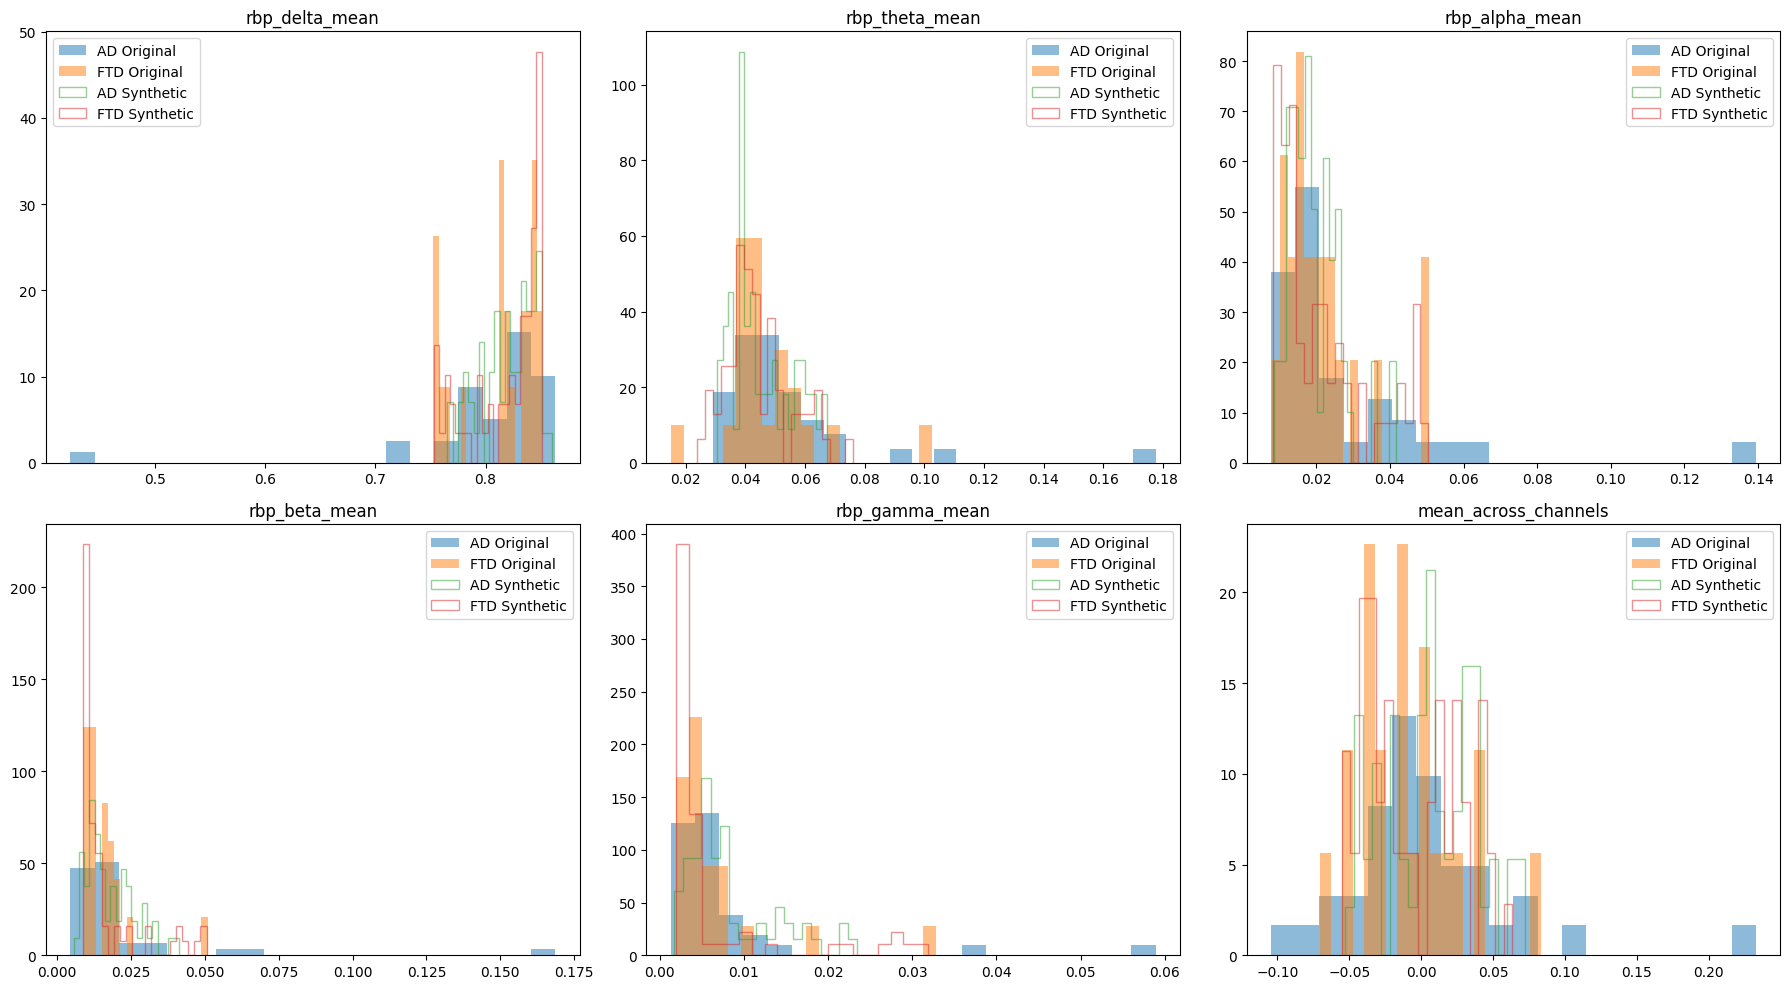


FINAL RESULTS SUMMARY
Original Data Test Accuracy: 0.5556
Augmented Data Test Accuracy: 0.7619
Improvement: 0.2063
Results saved to /kaggle/working/results.json
Training curves saved to /kaggle/working/training_curves.png
Feature distributions saved to /kaggle/working/feature_distributions.png


In [19]:
# ===================================================================
# STEP 5: VISUALIZATION
# ===================================================================

# Plot training losses for GANs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# GAN losses
axes[0, 0].plot(ad_g_losses, label='Generator')
axes[0, 0].plot(ad_d_losses, label='Discriminator')
axes[0, 0].set_title('AD GAN Training Losses')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(ftd_g_losses, label='Generator')
axes[0, 1].plot(ftd_d_losses, label='Discriminator')
axes[0, 1].set_title('FTD GAN Training Losses')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')

# CNN training losses
axes[1, 0].plot(orig_losses, label='Original Data')
axes[1, 0].plot(aug_losses, label='Augmented Data')
axes[1, 0].set_title('CNN Training Losses')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')

# CNN training accuracies
axes[1, 1].plot(orig_train_acc, label='Original Data')
axes[1, 1].plot(aug_train_acc, label='Augmented Data')
axes[1, 1].set_title('CNN Training Accuracies')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Compare feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(feature_cols[:6]):  # Plot first 6 features
    # Original data
    ad_orig = original_data[original_data['Group'] == 'A'][feature]
    ftd_orig = original_data[original_data['Group'] == 'F'][feature]
    
    # Synthetic data
    ad_synth = synthetic_ad_df[feature]
    ftd_synth = synthetic_ftd_df[feature]
    
    axes[i].hist(ad_orig, alpha=0.5, label='AD Original', bins=20, density=True)
    axes[i].hist(ftd_orig, alpha=0.5, label='FTD Original', bins=20, density=True)
    axes[i].hist(ad_synth, alpha=0.5, label='AD Synthetic', bins=20, density=True, histtype='step')
    axes[i].hist(ftd_synth, alpha=0.5, label='FTD Synthetic', bins=20, density=True, histtype='step')
    axes[i].set_title(f'{feature}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('/kaggle/working/feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Original Data Test Accuracy: {original_accuracy:.4f}")
print(f"Augmented Data Test Accuracy: {augmented_accuracy:.4f}")
print(f"Improvement: {augmented_accuracy - original_accuracy:.4f}")
print("="*60)

# Save results
results = {
    'original_accuracy': original_accuracy,
    'augmented_accuracy': augmented_accuracy,
    'improvement': augmented_accuracy - original_accuracy,
    'original_samples': len(original_data),
    'augmented_samples': len(augmented_features_df)
}

with open('/kaggle/working/results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to /kaggle/working/results.json")
print("Training curves saved to /kaggle/working/training_curves.png")
print("Feature distributions saved to /kaggle/working/feature_distributions.png")